## This is the notebook for project Object Detection

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
import time
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

### Helpfer Function

In [3]:
def plot_two_images(image1,image2,title1="original image",title2="modified image",figsize=(10,15)):
    """
        draw two images together
    """
    f,(ax1,ax2) = plt.subplots(1,2,figsize=figsize)
    ax1.set_title(title1)
    ax1.imshow(image1)
    ax2.set_title(title2)
    ax2.imshow(image2)

### Read Image

1196 1125
Your function returned a count of 1196  cars and 1125  non-cars
of size:  (64, 64, 3)  and data type: uint8
car image index is 159
notcar image index is 983


Text(0.5,1,'Example Not-car Image')

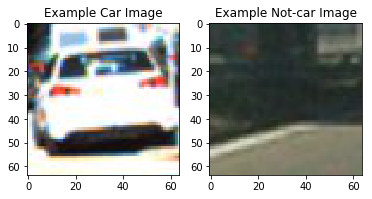

In [4]:
images = glob.glob(r'E:\Project\Udacity - Computer Vision\P5 Object Detection\TrainingData\*.jpeg')

cars = []
notcars = []

for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

print(len(cars),len(notcars))

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    test = plt.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
print("car image index is",car_ind)
print("notcar image index is",notcar_ind)
# Read in car / not-car images
car_image = plt.imread(cars[car_ind])
notcar_image = plt.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

Text(0.5,1,'Example Not-car Image')

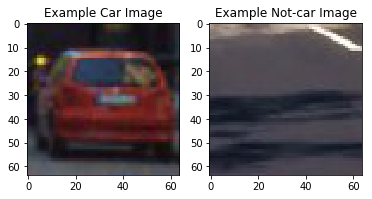

In [5]:
ExampleCarImg = plt.imread(cars[617])
ExampleNoncarImg = plt.imread(notcars[301])
fig = plt.figure()
plt.subplot(121)
plt.imshow(ExampleCarImg)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(ExampleNoncarImg)
plt.title('Example Not-car Image')

### Histogram of Oriented Gradient (HOG) Transformation

(-0.5, 63.5, 63.5, -0.5)

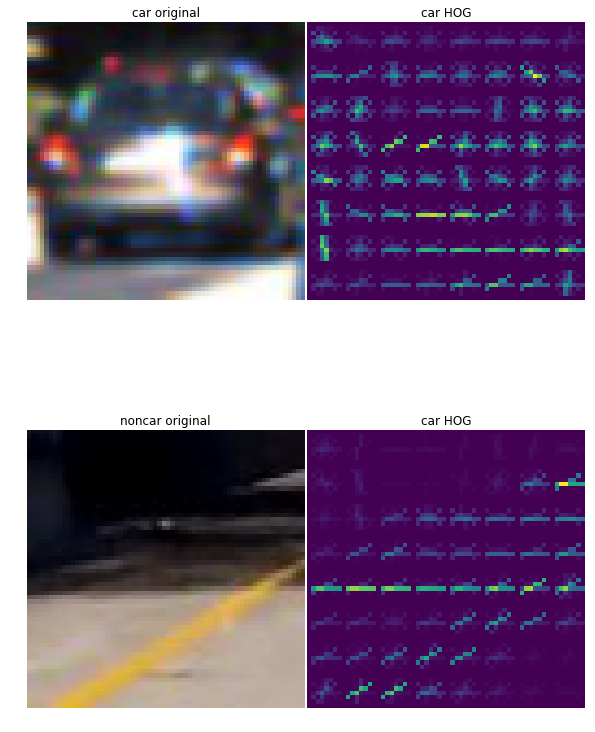

In [6]:
ExampleCarImg = plt.imread(cars[158])
ExampleNoncarImg = plt.imread(notcars[197])

# HOG transformation parameters
orient = 9 # number of orientation for binning
pixel_per_cell = 8 # pixel per cell for histogram
cell_per_block = 2 # cell per block for normalization (divided by L2 norm of vector of historgram value)
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

fvec_car, hog_car = hog(ExampleCarImg, orientations=orient, pixels_per_cell=(pixel_per_cell, pixel_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block), visualize=True, multichannel=True,block_norm="L2-Hys")
fvec_noncar, hog_noncar = hog(ExampleNoncarImg, orientations=orient, pixels_per_cell=(pixel_per_cell, pixel_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block), visualize=True, multichannel=True,block_norm="L2-Hys")

# viasulize
fig, axs = plt.subplots(2,2, figsize=(10, 15))
fig.subplots_adjust(hspace = .000002, wspace=.01)
axs = axs.ravel()

i = 0
axs[i].imshow(ExampleCarImg)
axs[i].set_title("car original")
axs[i].axis('off')
i += 1
axs[i].imshow(hog_car)
axs[i].set_title("car HOG")
axs[i].axis('off')
i += 1
axs[i].imshow(ExampleNoncarImg)
axs[i].set_title("noncar original")
axs[i].axis('off')
i += 1
axs[i].imshow(hog_noncar)
axs[i].set_title("car HOG")
axs[i].axis('off')

### Build SVM Classifier

#### Extract features for training data

In [53]:
# HOG transformation parameters
orient = 9 # number of orientation for binning
pixel_per_cell = 8 # pixel per cell for histogram
cell_per_block = 2 # cell per block for normalization (divided by L2 norm of vector of historgram value)
hog_channel="ALL"
colorspace = 'YUV'

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def pixel_feature(img, size=(32,32)):
    # Reshape an image to 32 by 32 size. And vectorize the feature
    features = cv2.resize(img,size).ravel()
    return features


def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel="ALL",hist_bins=9,hist_range=(0,255)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = plt.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # extract HOG features
        if hog_channel == 'ALL':
            hog_features = hog(feature_image, orientations=orient, pixels_per_cell=(pixel_per_cell, pixel_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block), visualize=False, multichannel=True,block_norm="L2-Hys")        
        else:
            hog_features = hog(feature_image[:,:,hog_channel],orientations=orient, pixels_per_cell=(pixel_per_cell, pixel_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block), visualize=False, multichannel=False,block_norm="L2-Hys")
        
        # extract color histogram 
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # extract vectorized pixel feature
        pixel_features = pixel_feature(feature_image)
        
        # combine all features
        all_feature = np.hstack((hog_features,hist_features,pixel_features))
        features.append(all_feature)
    # Return list of feature vectors
    return features

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pixel_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pixel_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')


9.35 Seconds to extract HOG features...


#### Build a classifier with extracted features

In [54]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
rand_state = 15
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=rand_state)

print(X.shape,y.shape,X_train.shape)


# feature normalization
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pixel_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC() # linear kernel
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Training Accuracy of SVC =', round(svc.score(X_train,y_train),4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


(2321, 4863) (2321,) (1624, 4863)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4863
0.58 Seconds to train SVC...
Training Accuracy of SVC = 1.0
Test Accuracy of SVC =  0.9842


### Sliding Window Search

(720, 1280, 3)


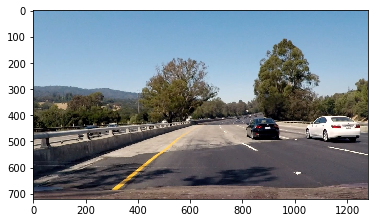

In [55]:
exampleImage_path = r'E:\Project\Udacity - Computer Vision\P5 Object Detection\test_image.jpg'
exampleImage = plt.imread(exampleImage_path)
plt.imshow(exampleImage)
print(exampleImage.shape)

(0.0, 1.0, 0.0, 1.0)

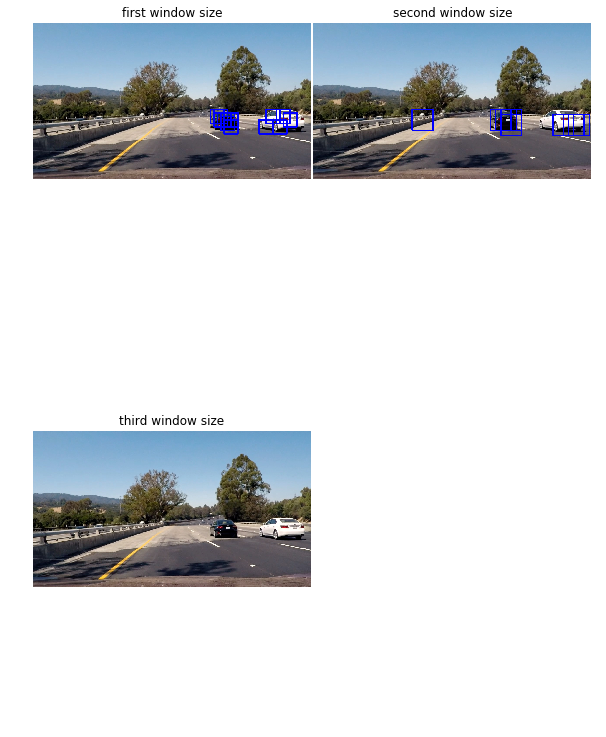

In [56]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,hist_bins=9,hist_range=(0,255)):
    """
    function to run slide windows on an image to detect cars
    
    Parameters
    
    ----------
    
    Return
    
    """
    bbox = []
    draw_img = np.copy(img) # image to be drew on
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
    img_tosearch = img[ystart:ystop,:,:] # define search area
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale))) # rescale image
    h,w = img_tosearch[:,:,0].shape
    # Define blocks and steps as above
    nxblocks = (w // pix_per_cell) - cell_per_block + 1
    nyblocks = (h // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    # extract HOG fature for the entire search area
    hog_feature = hog(img_tosearch, orientations=orient, pixels_per_cell=(pixel_per_cell, pixel_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block), visualize=False, multichannel=True,
                    block_norm="L2-Hys",feature_vector=False)
    
    # slide through the search area. steps by number of blocks. The hog features must have the same dimension as
    # the input SVM model
    for xb in range(nxsteps):
        for yb in range(nysteps):
            
            # subsample HOG feature
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            hog_features = hog_feature[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # ================== feature extraction =========================
            
            # extract color-histogram feature
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64)) #subsample image
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)
            
            # extract vectorized pixel value
            pixel_features = pixel_feature(subimg)
        
            # combine all features
            all_features = np.hstack((hog_features,hist_features,pixel_features))
            
            test_features = X_scaler.transform(all_features.reshape(1,-1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                bbox.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    return draw_img,bbox

# define search parameters

pixel_per_cell = 8 # pixel per cell for histogram
cell_per_block = 2 # cell per block for normalization (divided by L2 norm of vector of historgram value)
orient = 9

ystart = 400
ystop = 550
scale = 1
img_scale1,bbox1 = find_cars(exampleImage, ystart, ystop, scale, svc, X_scaler, orient, pixel_per_cell, cell_per_block)

ystart = 400
ystop = 600
scale = 1.5
img_scale2,bbox2 = find_cars(exampleImage, ystart, ystop, scale, svc, X_scaler, orient, pixel_per_cell, cell_per_block)

ystart = 450
ystop = 700
scale = 2
img_scale3,bbox3 = find_cars(exampleImage, ystart, ystop, scale, svc, X_scaler, orient, pixel_per_cell, cell_per_block)

## visualize the detected area

fig, axs = plt.subplots(2,2,figsize=(10,15))
fig.subplots_adjust(hspace = 0, wspace=.01)
axs = axs.ravel()

i = 0
axs[i].imshow(img_scale1)
axs[i].set_title("first window size")
axs[i].axis('off')
i += 1
axs[i].imshow(img_scale2)
axs[i].set_title("second window size")
axs[i].axis('off')

i += 1
axs[i].imshow(img_scale3)
axs[i].set_title("third window size")
axs[i].axis('off')

i += 1
axs[i].axis('off')

#### Refind Detection and Remove False Positive

(720, 1280)


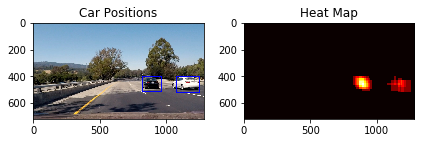

In [57]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    """
    add heat(+1) for pixels in each box
        
    
    @parameters:
    ================
    heatmap: array of size by (height, width)
    
    bbox_list: list of bbox coordiate
    
    """
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    """
    Zero out pixels below the threshold
    """
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    """
    @parameters:
    =================================
    labels: tuple of 2 elements (array of unique features,number of features)
    """
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

bbox = bbox1 + bbox2 + bbox3
heat = np.zeros_like(exampleImage[:,:,0]).astype(np.float)
print(heat.shape)
# Add heat to each box in box list
heat = add_heat(heat,bbox)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function

"""
# ========= label function from scipy package ======================

Label features in an array. An array-like object to be labeled. 

Any non-zero values in input are counted as features and zero values are considered the background.
 
Returns:
    label : ndarray or int

    An integer ndarray where each unique feature in input has a unique label in the returned array.

    num_features : int

    How many objects were found.

    If output is None, this function returns a tuple of (labeled_array, num_features).

    If output is a ndarray, then it will be updated with values in labeled_array and only num_features will be returned by this function.

# ==================================================================
"""

labels = label(heatmap)

draw_img = draw_labeled_bboxes(np.copy(exampleImage), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()




### Build a Class to Track Heatmap

In [58]:
"""
    The heatmap method on a single frame produces flickering bounding box on a series of frames. Therefore we need to
    leverage temporal information to smooth bounding boxes over frames.
"""

class Heatmap():
    def __init__(self,n):
        """
        @parameters:
        ---------------
        n: number of recent frames to keep
        """
        self.heatmaps = []
        self.n = n
    def add(self,heatmap):
        """add new heatmap"""
        self.heatmaps.append(heatmap)
        self.heatmaps = self.heatmaps[-self.n:] # only keep the most recent n elements
        
    def average(self):
        output_heatmap = np.mean(self.heatmaps,axis=0) # average heatmaps over most recent n elements
        return output_heatmap

### Pipeline to detect vehicle

In [67]:
heat_threshold = 2
heatmap_tracker = Heatmap(15)

def process_image(img):
    """
    pipeline function to detect vehicle 
    
    Parameters:
    ------------
    img: a frame/image
        
    Returns:
    ------------
    result_img: image with bounding box
     
    """
    
    # ========== slide window search by multiple scale =========================
    bboxes = [] # list to restore bbox for each search
    for i in range(len(scale_array)):
        ystart = y_array[i][0]
        ystop = y_array[i][1]
        scale = scale_array[i]
        img_scale,bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pixel_per_cell, cell_per_block)
        bboxes.extend(bbox)
    
    # ========== refine multiple detection and remove false positive ==========
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,bboxes) # Add heat to each box in box list

    # ========== temporal difference smoothing ================================
    heatmap_tracker.add(heat)
    heat = heatmap_tracker.average()
    
    # ========== thresholding =================================================
    heat = apply_threshold(heat,heat_threshold) # Apply threshold to help remove false positives
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    result_img = draw_labeled_bboxes(np.copy(img), labels)
    return result_img

### Test pipeline images

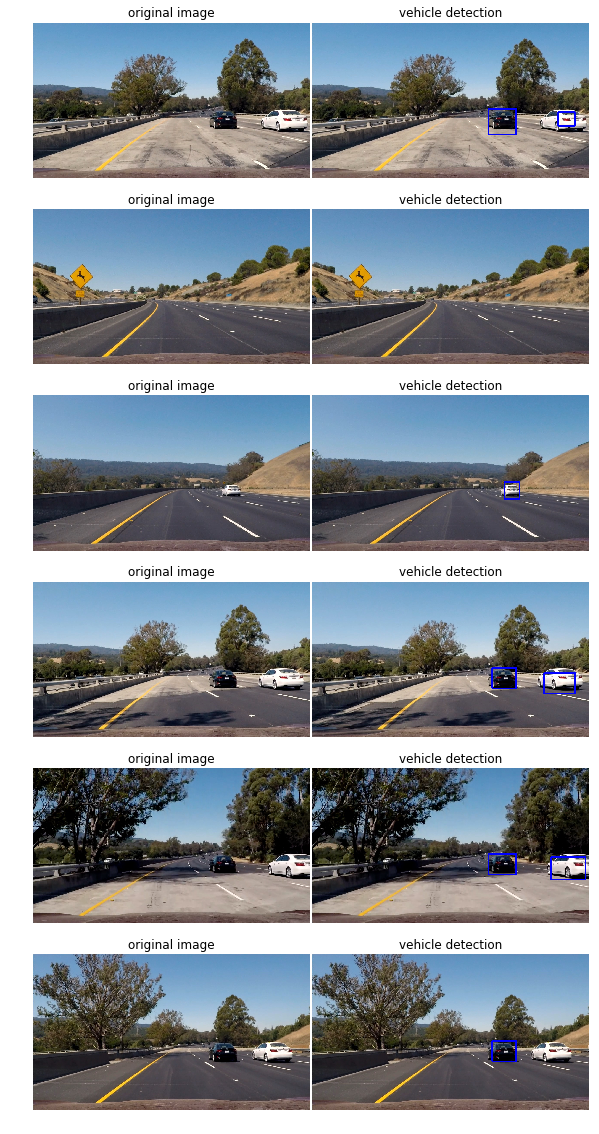

In [68]:
scale_array = [1.0,1.5,2.5]
y_array = [(400,600),(400,650),(500,700)]

images = glob.glob(r'E:\Project\Udacity - Computer Vision\P5 Object Detection\Test Image\*.jpg')

# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

i = 0
for image_path in images:
    heatmap_tracker = Heatmap(1)
    img = plt.imread(image_path)
    result=process_image(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title('original image')
    i += 1
    axs[i].imshow(result)
    axs[i].axis('off')
    axs[i].set_title('vehicle detection')
    i += 1

### Processing Test Video

#### No Producer's Name

In [63]:
from moviepy.editor import *
from IPython.display import HTML
heatmap_tracker = Heatmap(15)
def create_video(raw_video_path,output_path):
    raw_video = VideoFileClip(raw_video_path,audio=False)
    processed_clip = raw_video.fl_image(process_image)
    raw_video.reader.close() # 
    %time processed_clip.subclip(0,processed_clip.duration).write_videofile(output_path, audio=False)
    del raw_video.reader #

In [64]:
input_video = r'E:\Project\Udacity - Computer Vision\P5 Object Detection\test_video.mp4'
output_video = r'E:\Project\Udacity - Computer Vision\P5 Object Detection\test_output_video.mp4'
create_video(input_video,output_video)

[MoviePy] >>>> Building video E:\Project\Udacity - Computer Vision\P5 Object Detection\test_output_video.mp4
[MoviePy] Writing video E:\Project\Udacity - Computer Vision\P5 Object Detection\test_output_video.mp4


 97%|████████████████████████████████████████▉ | 38/39 [01:12<00:01,  1.91s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: E:\Project\Udacity - Computer Vision\P5 Object Detection\test_output_video.mp4 

Wall time: 1min 16s


### Processing Project Video

#### With Producer's Name

In [69]:
from moviepy.editor import *
from IPython.display import HTML
heatmap_tracker = Heatmap(15)
def create_video(raw_video_path,output_path):
    raw_video = VideoFileClip(raw_video_path,audio=False)
    processed_clip = raw_video.fl_image(process_image)
    txt = TextClip("Produced by Wenbo Ma for Vehicle Detection Project", font='Amiri-regular',
	               color='white',fontsize=20)
    txt_col= txt.on_color(size=(processed_clip.w + txt.w,txt.h-5),
                  color=(0,0,0), pos=(6,'center'), col_opacity=0.6)
    w,h = processed_clip.size
    txt_mov = txt_col.set_pos(lambda t: (max(w/30,int(w-0.5*w*t)),40))
    composite_clip = CompositeVideoClip([processed_clip, txt_mov])
    raw_video.reader.close() #
    %time composite_clip.subclip(0,processed_clip.duration).write_videofile(output_path, audio=False)
    del raw_video.reader #

In [70]:
input_video = r'E:\Project\Udacity - Computer Vision\P5 Object Detection\project_video.mp4'
output_video = r'E:\Project\Udacity - Computer Vision\P5 Object Detection\project_output_video.mp4'
create_video(input_video,output_video)

[MoviePy] >>>> Building video E:\Project\Udacity - Computer Vision\P5 Object Detection\project_output_video.mp4
[MoviePy] Writing video E:\Project\Udacity - Computer Vision\P5 Object Detection\project_output_video.mp4


100%|███████████████████████████████████▉| 1260/1261 [1:15:28<00:03,  3.59s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: E:\Project\Udacity - Computer Vision\P5 Object Detection\project_output_video.mp4 

Wall time: 1h 15min 53s
